# Challenge description

Alert incident in transactions: Implement the concept of a simple monitoring with real time alert with notifications to teams.

The monitoring works by receiving information about a transaction and inferring whether it is a failed or denied, or reversed or aprroved transaction. We work mostly with SQL, PromQL, Ruby and Python, but you can use any programming language that you want.

Please use the data of [transactions1] and the data of [transactions2]. Consider that transactions with the flag denied are transactions denied by risk of the issuers. Consider that transactions with the flag reversed or failed are transactions with problems. Note: F1 represents the quantity of transactions per minute from all POS from our costumers. So with this data you can see the diferent status per minute and see if it is going well or not. When you see the padron, you can predict a alarm for the anomaly.

Your Monitoring alert system must have at least: 1 endpoint that receives transaction data and returns a recommendation to “alert” the anomalies found in transactions. A query to organize the data on the data and a graphic to see the data in real time. A model to determine anomalies and a system to report the anomalies automatically.

You are free to determine the methods to approve/deny the transactions, but a few ways to do it are:

1. rule-based - you define which cases get alerted based on predefined rules;
2. score-base - you create a method/model (you could use machine learning models here if you want) to determine the anomaly -- score of a transaction and make your decision based on it;
3. a combination of both;

**Monitoring alert Requirements**:

a. Alert transactions if failed transactions are above normal;

b. Alert transactions if reversed transactions are above normal;

c. Alert transactions if denied transactions are above normal;

# Importing Modules

In [1]:
import pickle

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

from datetime             import datetime, date, timedelta
from matplotlib.dates     import DateFormatter
from IPython.display      import HTML, display, clear_output
from matplotlib.animation import FuncAnimation

In [2]:
# Adjust the width of the display container to 100%
display(HTML("<style>.container { width:100% !important; }</style>"))

# Set the font size for rendered HTML to 17px
display(HTML("<style>.rendered_html { font-size: 17px; }</style>"))

In [3]:
%matplotlib notebook

# Monitoring Alert System 

This is my approach:

    1. By using the z-score approach, I identify and remove outliers from the time series (e.g, transactions 1). This step is crucial for establishing a baseline or "normal day" without the influence of extreme values. Then, we obtain the mean and the standard deviation of this 'regular day' time series.

    2. Now considering each value in the original time series, I calculate its z-score based on the mean and standard deviation of the "regular day".

    3. If the z-score of the current value is greater than a certain threshold (expressed in standard deviations), I flag it as an anomaly. This step identifies deviations from the established baseline, indicating unusual datapoints.

Even though this approach is not ideal, this is a practical method when the dataset representing a 'regular day' is unavailable.

## Getting the "regular days" means and standard deviations

In [12]:
def detect_anomalies(array, threshold=3):
    """
    Detect anomalies in the given array based on z-scores.

    Parameters:
    - array (numpy.ndarray): Input array containing numerical data.
    - threshold (float, optional): Threshold for considering a data point as an anomaly. Default is 3.

    Returns:
    - anomaly_indices (numpy.ndarray): Indices of anomalous data points in the array.
    """
    
    # Calculate z-scores for the array
    z_scores = (array - np.mean(array)) / np.std(array)
    
    # Identify indices where absolute z-scores exceed the threshold
    anomaly_indices = np.where(np.abs(z_scores) > threshold)[0]

    return anomaly_indices

In [13]:
def filter_array(array, indices):
    """
    Filter elements of a NumPy array based on a list of indices.

    Parameters:
    - array (numpy.ndarray): Input array.
    - indices (list): List of indices to exclude from the array.

    Returns:
    - filtered_array (numpy.ndarray): Array with elements corresponding to the given indices removed.
    """
    
    # Create a boolean mask with True for elements not in the given indices
    mask = np.ones(array.size, dtype=bool)
    mask[indices] = False
    
    # Apply the mask to filter the array
    filtered_array = array[mask]
    
    return filtered_array

In [14]:
# Define a list for the dataset names 
transactions = ['transactions_1', 'transactions_2']

# Define a list of transaction statuses we are going to be using
statuses = ['denied',  'failed',  'reversed']

# Define a list of colors for different transaction statuses
colors = ['#e41a1c', '#a65628', '#4daf4a']

# Create a dictionary mapping each transaction status to its corresponding color
colors_dict  = dict(zip(statuses, colors))

In [15]:
# Initialize an empty dictionary to store regular day statistics for each transaction time series
transactions_regulardays = {}

# Iterate through each transaction time series
for transaction in transactions:
    # Initialize a dictionary to store statistics for each status
    regular_day_statistics_dict = {}
    
    # Iterate through each status
    for status in statuses:
        # Read the transactions dataset for the current transaction
        transactions_df = pd.read_csv(f'transactions_datasets/{transaction}.csv', names=['time', 'status', 'F1'], header=0)
        
        # Pivot the DataFrame to get a timeseries for the specified status
        pivot_df = transactions_df.pivot_table(index='time', columns='status', values='F1', aggfunc='max', fill_value=0)
        
        # Extract the timeseries for the current status
        timeseries = pivot_df[status].values
        nonzero_timeseries = timeseries[timeseries != 0]

        # Get timeseries without anomalies ("normal day")
        anomalies_indices = detect_anomalies(nonzero_timeseries)
        nonzero_timeseries_without_anomalies = filter_array(nonzero_timeseries, anomalies_indices) 

        # Calculate mean and standard deviation for the regular day
        mean_regularday, std_regularday = np.mean(nonzero_timeseries_without_anomalies), np.std(nonzero_timeseries_without_anomalies)

        # Store the statistics in the dictionary
        regular_day_statistics_dict[status] = [mean_regularday, std_regularday]
    
    # Store the regular day statistics for the current transaction in the main dictionary
    transactions_regulardays[transaction] = regular_day_statistics_dict

In [16]:
# Save the transactions_regulardays dictionary using pickle
pickle.dump(transactions_regulardays, open("transactions_datasets/transactions_regulardays_dict.p", "wb"))

In [17]:
transactions_regulardays

{'transactions_1': {'denied': [20.89108910891089, 15.923529617629026],
  'failed': [1.2830188679245282, 0.6257782623312076],
  'reversed': [16.91891891891892, 32.71125406929157]},
 'transactions_2': {'denied': [23.9501312335958, 15.008838384151199],
  'failed': [7.493975903614458, 3.5291334612580423],
  'reversed': [2.1149110807113543, 1.233563603735122]}}

In [ ]:
################################################################################################################################################################################################################################################################################################################################################################################################################################

# Setting up the matplotlib animations

Ok. So, now I have the averages and standard deviations of regular days (both for transactions_1 and transactions_2).

I'll create a maptlotlib animation that shows the time series. For each datapoint (e.g, from transactions_1), I'll calculate its z-score based on the means and stds of transactions_1 without anomalies ("normal day").

Then, if the z-score is higher than the threshold, I'll flag it as an anomaly. 

In [19]:
def detect_anomalies_in_real_time(mean_regularday, std_regularday, current_value, threshold=3):
    """
    Detect anomalies based on the mean and standard deviation of a regular day.

    Parameters:
    - mean_regularday (float): Mean value for a regular day.
    - std_regularday (float): Standard deviation for a regular day.
    - current_value (float): Current value to check for anomaly.
    - threshold (float, optional): Z-score threshold for anomaly detection. Defaults to 3.

    Returns:
    - bool: True if the current value is considered an anomaly, False otherwise.
    """
    
    # Calculate the z-score for the current value
    z_score = (current_value - mean_regularday) / std_regularday
    
    # Check if the absolute value of the z-score exceeds the threshold
    return np.abs(z_score) > threshold

In [20]:
# Load the transactions_regulardays dictionary using pickle
transactions_regulardays = pickle.load(open("transactions_datasets/transactions_regulardays_dict.p", "rb"))

In [22]:
# Which transaction are we dealing with? and status type?
# Set the transaction and status
transaction, status = 'transactions_2', 'reversed'

# Extract mean and standard deviation for the specified status from the transactions_regulardays dictionary
mean_regularday, std_regularday = transactions_regulardays[transaction][status][0], transactions_regulardays[transaction][status][1]

# Read the transactions dataset for the specified transaction
transactions_df = pd.read_csv(f'transactions_datasets/{transaction}.csv', names=['time', 'status', 'F1'], header=0)

# Format the time column and convert it to datetime object
transactions_df['time'] = transactions_df['time'].apply(lambda x: x.replace('h ', ':'))
transactions_df['time'] = pd.to_datetime(transactions_df['time'], format='%H:%M').dt.time

# Pivot the DataFrame to create a timeseries with 'time' as index, 'status' as columns, and 'F1' as values
pivot_df = transactions_df.pivot_table(index='time', columns='status', values='F1', aggfunc='max', fill_value=0)

<IPython.core.display.Javascript object>


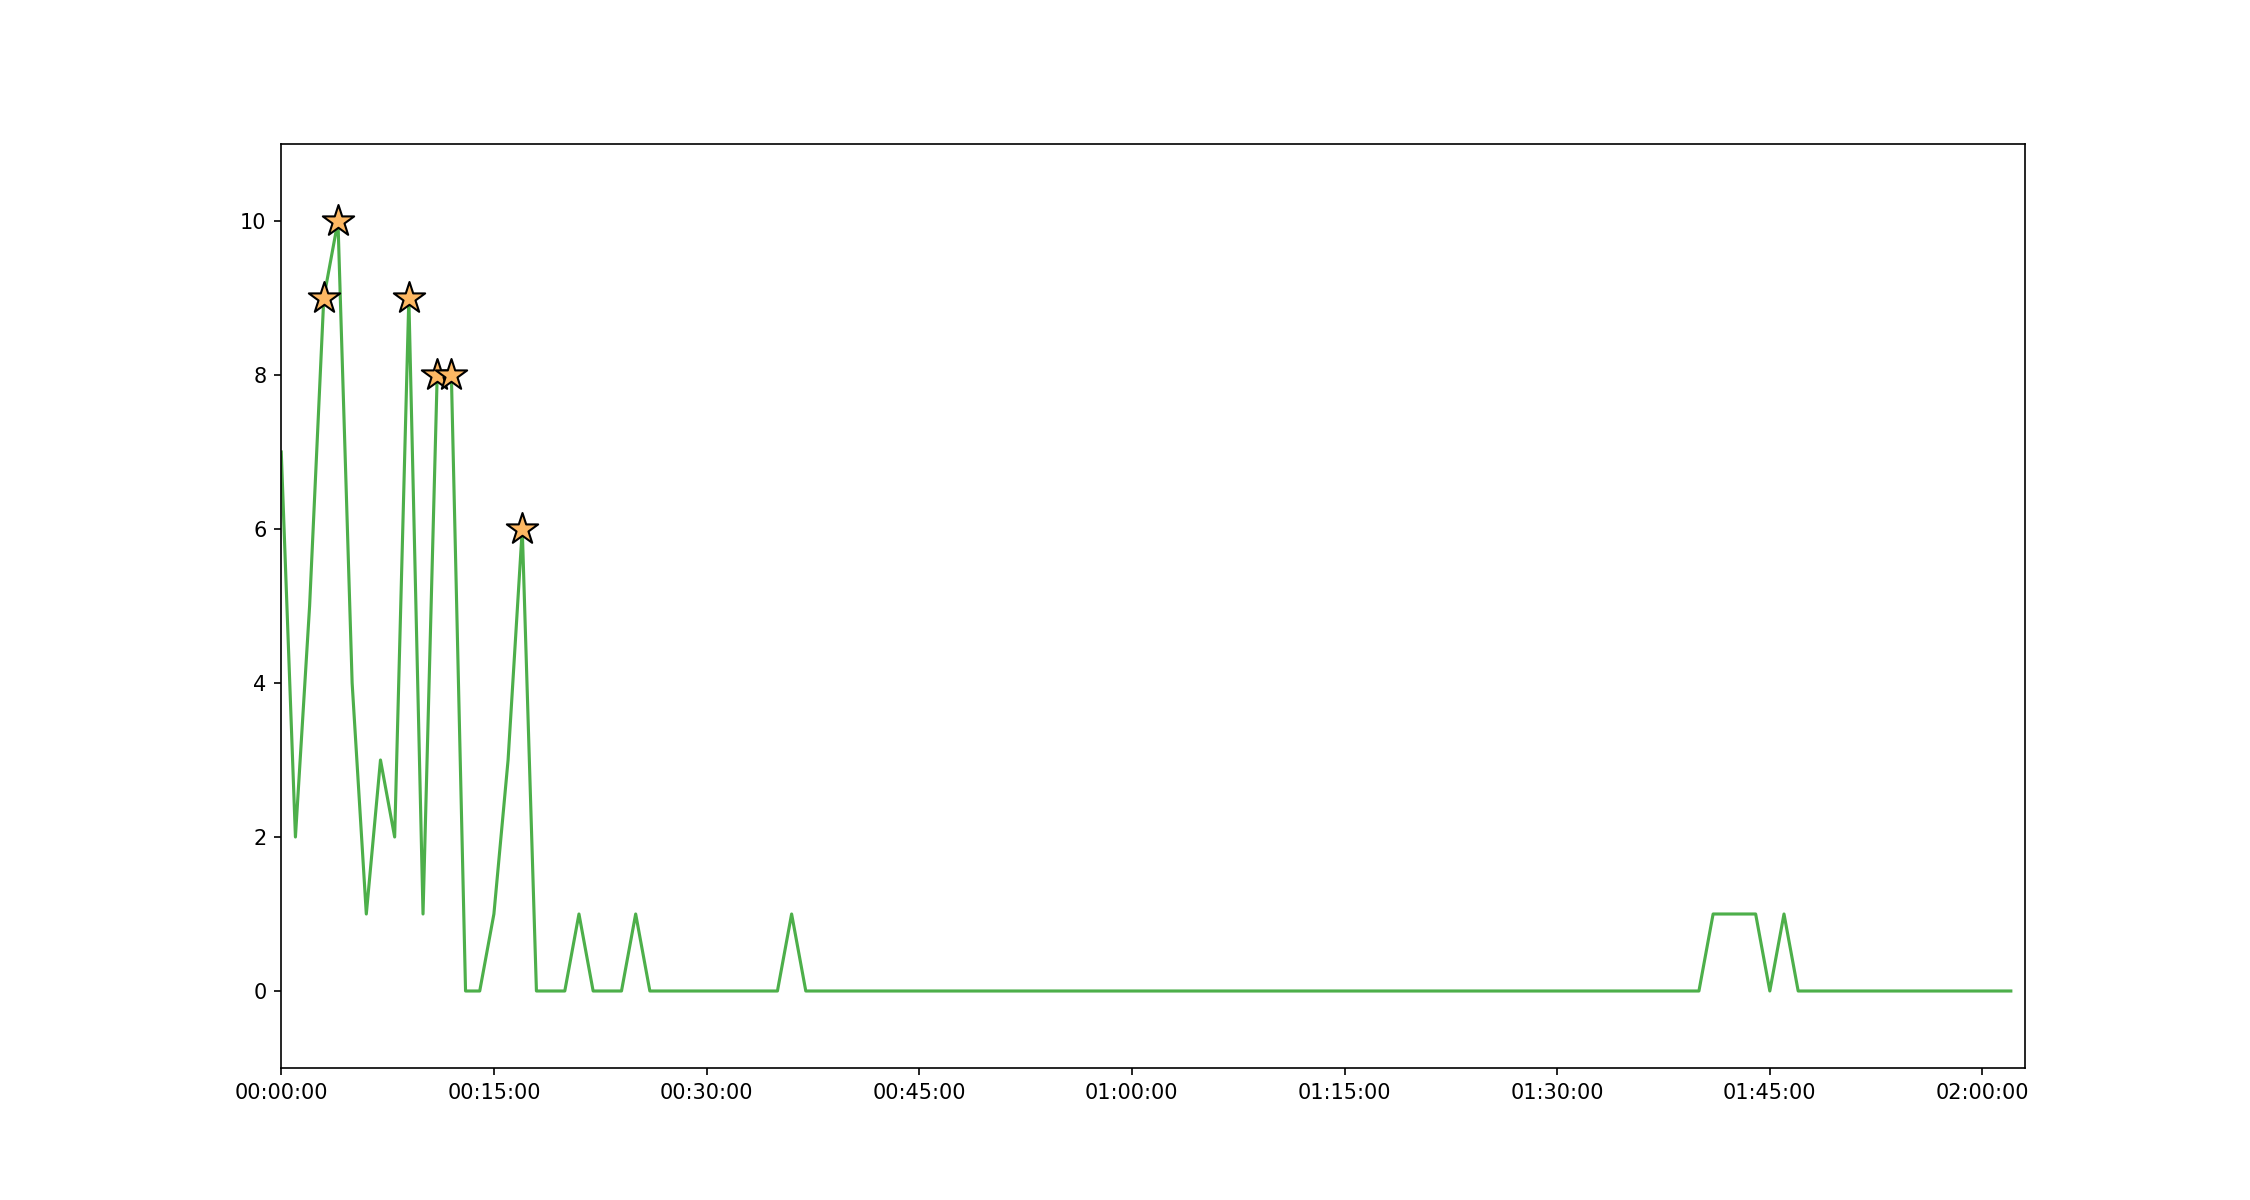

In [23]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(15, 8))

# Prepare x and y data
x_data = [datetime.combine(date.today(), t) for t in pivot_df[status].index]
y_data = pivot_df[status].values

# Initialize the plot with the first data point
line, = ax.plot(x_data[:1], y_data[:1], color=colors_dict[status])

# Function to update the plot for each frame in the animation
def update(frame):
    new_value = y_data[frame + 1]
    
    # Update the plot data up to the current frame
    line.set_data(x_data[:frame + 1], y_data[:frame + 1])
    
    # Detect anomalies in real-time
    is_anomalous = detect_anomalies_in_real_time(mean_regularday, std_regularday, new_value, threshold=3)
    
    # If the current value is anomalous, highlight it with a star marker
    if is_anomalous:
        ax.scatter(x=x_data[frame + 1], y=new_value, marker='*', zorder=10, s=250, color='#fdb863', edgecolor='k')

    # Set x-axis limit up to the current frame and adjust y-axis limit dynamically
    ax.set_xlim(x_data[0], x_data[frame + 1])

    min_y, max_y = min(y_data[:frame + 1]), max(y_data[:frame + 1])
    buffer = 0.1 * (max_y - min_y) 
    ax.set_ylim(min_y - buffer, max_y + buffer)

    # Format x-axis as time
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))
    
    # Clear the previous frame
    clear_output(wait=True)
    
    # Display the updated figure
    display(fig)

# Create the animation with frames and interval
animation = FuncAnimation(fig, update, frames=len(x_data) - 1, interval=20, blit=True)

# Show the animation
plt.show()

I want to display the three status. So let's do that.

In [24]:
def animate_status(ax, fig, status, df, transaction):
    # Extract mean and standard deviation for the specified status and transaction
    mean_regularday, std_regularday = transactions_regulardays[transaction][status][0], transactions_regulardays[transaction][status][1]

    # Prepare x and y data for the animation
    x_data = [datetime.combine(date.today(), t) for t in df[status].index]
    y_data = df[status].values

    # Initialize the plot with the first data point
    line, = ax.plot(x_data[:1], y_data[:1], color=colors_dict[status])

    # Set the y-axis label
    ax.set_ylabel(status.capitalize(), fontsize=15)
    
    # Create annotations for displaying information
    annotation1 = ax.annotate("", xy=(0.5, 1.1), xycoords='axes fraction', ha='center', va='center', fontsize=15, bbox=dict(boxstyle="round,pad=0.3", ec="k", fc='w', lw=0.9))
    annotation2 = ax.annotate("", xy=(0.5, 0.9), xycoords='axes fraction', ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", ec="k", fc='w', lw=0.9))

    # Function to update the plot for each frame in the animation
    def update(frame):
        new_value = y_data[frame]

        # Update the plot data up to the current frame
        line.set_data(x_data[:frame + 1], y_data[:frame + 1])

        # Detect anomalies in real-time
        is_anomalous = detect_anomalies_in_real_time(mean_regularday, std_regularday, new_value, threshold=3)

        # If the current value is anomalous, highlight it with a star marker and update annotations
        if is_anomalous:
            ax.scatter(x=x_data[frame], y=new_value, marker='*', zorder=10, s=250, color='#fdb863', edgecolor='k')
            
            annotation1.set_text(f"{status.capitalize()} transactions are above normal!")
            annotation1.set_color(colors_dict[status])
            
            annotation2.set_text(f"Latest anomaly: {new_value} transactions at {x_data[frame].time()}")
            annotation2.set_color('k')
        else:
            # If not anomalous, clear the annotations
            annotation1.set_text("")

        # Set x-axis limit up to the current frame and adjust y-axis limit dynamically
        ax.set_xlim(x_data[0] - timedelta(minutes=1), x_data[frame + 1])

        max_y = max(y_data[:frame + 1])
        buffer = 0.4 * max_y
        ax.set_ylim(0, max_y + buffer)

        # Format x-axis as time
        ax.xaxis.set_major_formatter(DateFormatter('%H:%M:%S'))

    # Create the animation with interval and blit
    anim = FuncAnimation(fig, update, interval=100, blit=True)
    
    # Clear the previous frame and display the updated figure
    clear_output(wait=True)
    display(fig)
    
    return anim

In [27]:
# Define the transaction and read the corresponding CSV file
transaction = 'transactions_2'
transactions_df = pd.read_csv(f'transactions_datasets/{transaction}.csv', names=['time', 'status', 'F1'], header=0)

# Preprocess the 'time' column to replace 'h ' with ':' and convert it to time format
transactions_df['time'] = transactions_df.time.apply(lambda x: x.replace('h ', ':'))
transactions_df['time'] = pd.to_datetime(transactions_df['time'], format='%H:%M').dt.time

# Create a pivot table to organize the data with time as index, status as columns, and 'F1' as values
df = transactions_df.pivot_table(index='time', columns='status', values='F1', aggfunc='max', fill_value=0)

<IPython.core.display.Javascript object>


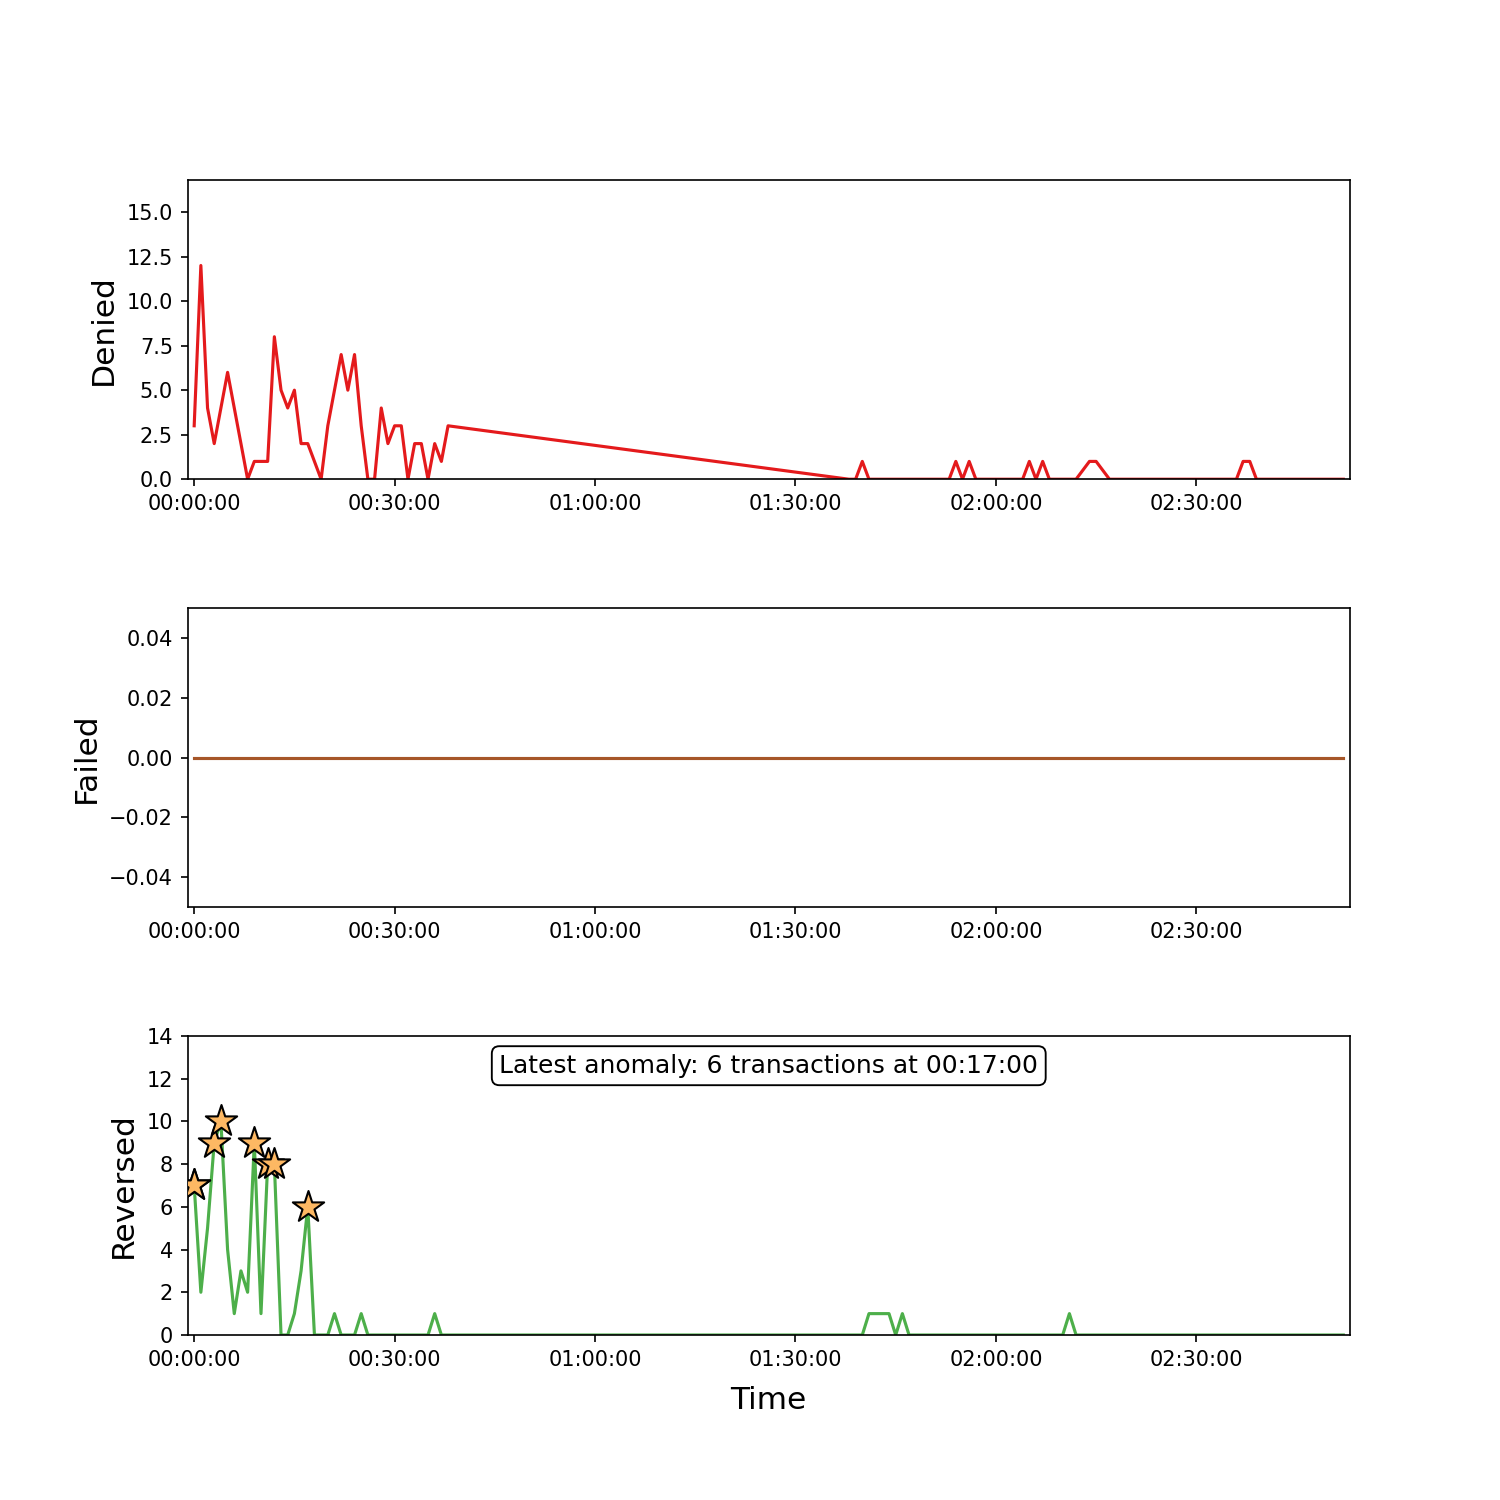

In [28]:
# Create subplots for each status and display real-time animations
fig, axs = plt.subplots(nrows=3, figsize=(10, 10))

# Create a list of animations for each status
animations = [animate_status(ax, fig, status, df, transaction) for ax, status in zip(axs, statuses)]

# Set x-axis label and adjust subplot spacing
axs[-1].set_xlabel('Time', fontsize=15, labelpad=8)
plt.subplots_adjust(hspace=0.43)

# Display the plot with real-time animations
plt.show()